## Data Reading and Transformation
The data (BCI Arboreal) has a lot of fields which are NaN and a lot of irrelevant variables for my analysis right now I only require location (X, Y, UTM-north, UTM-east) 
Time(timestamp)
Name fields

So I run queries to filter out the above fields and remove any empty data fields from the dataframe

In [198]:
import pandas as pd
import numpy as np
df = pd.read_csv('data/Dead-Reckoning Arboreal Species in BCI.csv')
# convert the timestamp column to Unix timestamps
df['timestamp'] = pd.to_datetime(df['timestamp']).apply(lambda x: x.timestamp())

# convert the Unix timestamps to integers
df['timestamp'] = df['timestamp'].astype(int)

/var/folders/2z/k0vctg855l3dq626nd2hf5j40000gn/T/ipykernel_12104/2044101010.py:3: DtypeWarning: Columns (7,9,18,32,37,46) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/Dead-Reckoning Arboreal Species in BCI.csv')


In [199]:
### This assumes we've already got a list of trajectories and we are refining them
### Given a list of coordinates how to find diff trajectories

### change in animal - change in day - too much gap bw 2 points (just basic measures which are 100% sure of trajectories) 

After reading the data. I'm only taking the GPS sensor logs. I tried to merge the records of other sensors (acc / mag). The only reasonable field I thought would be timestamp however the records didn't match good enough so only keeping the GPS data for now

### Preprocessing and finding out trajectories

For each of the animals I'm just listing out every different day and an animal as a distinct trajectory 
which is pretty basic

In [200]:
##Considering the GPS data for this study
df_gps = df[df['sensor-type'] == 'gps']
df_gps = df_gps[['event-id', 'timestamp', 'location-long', 'location-lat', 'utm-easting', 'utm-northing', 'study-local-timestamp', 'individual-local-identifier']]
df_gps['study-local-timestamp'] = pd.to_datetime(df_gps['study-local-timestamp'])

# df_gps.dropna(axis = 1, inplace = True)
df_extract = df_gps[['utm-easting', 'utm-northing', 'timestamp']]


In [201]:
df_gps['date'] = df_gps['study-local-timestamp'].dt.date 

In [202]:
df_gps['date'] = df_gps['date'].apply(lambda x: x.strftime('%Y-%m-%d'))
# df['date']

In [203]:
df_gps['grouping_column'] = df_gps['date'] + ' ' + df_gps['individual-local-identifier']
df_gps['trajectory_number'] = pd.factorize(df_gps['grouping_column'])[0]


### List the 6 steps for the thing I'm doing right now

### 1. extract characteristic points from the trajectories;


In [204]:
import math

def get_mean(lst):
    return sum(lst) / len(lst)

def spatial_distance(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

def angle_between_vectors(v1, v2):
    dot_product = v1[0] * v2[0] + v1[1] * v2[1]
    magnitude_product = math.sqrt(v1[0]**2 + v1[1]**2) * math.sqrt(v2[0]**2 + v2[1]**2)
    return math.degrees(math.acos(dot_product / magnitude_product))



def extract_significant_points(points, min_distance = 3, max_distance = 10, min_angle = 30, min_stop_duration = 100):

    n = len(points)
    C = [points[0]]
    i = 0
    j = 1

    while j < n:
        
        if j == n - 1:
            C.append(points[j])
            break

        d_space_i_j = spatial_distance(points[i][:2], points[j][:2])
        if d_space_i_j >= max_distance:
            C.append(points[j])
            i = j
            j = i + 1
        #Fine
        else:
            k = j + 1
            while k < n and spatial_distance(points[j][:2], points[k][:2]) < min_distance:
                k = k + 1
            #Fine
            if k > j + 1:
                d_time = points[k-1][2] - points[j][2]
                if d_time >= min_stop_duration:
                    C.append(points[j])
                    i = j
                    j = k
                    
            #Fine
                else:
                    x_vals, y_vals, t_vals = zip(*points[j:k])
                    x_ave = get_mean(x_vals)
                    y_ave = get_mean(y_vals)

                    distances = [spatial_distance((x, y), (x_ave, y_ave)) for x, y, _ in points[j:k]]
                    m = j + distances.index(min(distances))

                    C.append(points[m])
                    i = j
                    j = m + 1

            else:
                a_turn = angle_between_vectors((points[i][0] - points[j][0], points[i][1] - points[j][1]),
                                               (points[j][0] - points[k][0], points[j][1] - points[k][1]))
                if a_turn >= min_angle:
                    C.append(points[j])
                    i = j
                    j = k
                else:
                    j += 1

    return C


In [205]:
extracted_points = extract_significant_points(df_extract.to_numpy(), 10, 30, 15, 100)
extracted_points = pd.DataFrame(extracted_points, columns=['utm-easting', 'utm-northing', 'timestamp'])
extracted_points = pd.merge(extracted_points, df_gps, on = ['utm-easting', 'utm-northing', 'timestamp'])


/var/folders/2z/k0vctg855l3dq626nd2hf5j40000gn/T/ipykernel_12104/454117688.py:12: RuntimeWarning: invalid value encountered in double_scalars
  return math.degrees(math.acos(dot_product / magnitude_product))


In [206]:
extracted_points.to_csv('data/BCI-movement-data.csv')

In [207]:
import math
from typing import List, Tuple, Set, Optional

class Point:
    def __init__(self, x: float, y: float):
        self.x = x
        self.y = y

class Group:
    def __init__(self, centroid: Point, members: Optional[Set[Point]] = None):
        if members is None:
            members = set([centroid])
        else:
            members.add(centroid)
        self.centroid = centroid
        self.members = members


        

class Grid:
    def __init__(self, x_min: float, x_max: float, y_min: float, y_max: float, max_radius: float):
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.max_radius = max_radius
        self.n_rows = math.ceil((y_max - y_min) / max_radius)
        self.n_cols = math.ceil((x_max - x_min) / max_radius)
        self.cells = [[set() for _ in range(self.n_cols)] for _ in range(self.n_rows)]

    def get_grid_position(self, point: Point) -> Tuple[int, int]:
        i = math.floor((point.y - self.y_min) / self.max_radius)
        j = math.floor((point.x - self.x_min) / self.max_radius)
        return i, j

    def get_closest_centroid(self, point: Point) -> Group:
        i, j = self.get_grid_position(point)
        c = None
        for row in range(max(i - 1, 0), min(i + 2, self.n_rows)):
            for col in range(max(j - 1, 0), min(j + 2, self.n_cols)):
                for centroid in self.cells[row][col]:
                    if self._spatial_distance(point, centroid) <= self.max_radius:
                        if c is None or self._spatial_distance(point, centroid) < self._spatial_distance(point, c.centroid):
                            c = Group(centroid, set())
        return c
    
    def add_element(self, i, j, point):
        self.cells[i][j].add(point)


    def add_centroid(self, group: Group):
        i, j = self.get_grid_position(group.centroid)
        self.cells[i][j].add(group.centroid)

    def remove_centroid(self, group: Group):
        i, j = self.get_grid_position(group.centroid)
        self.cells[i][j].remove(group.centroid)

    def _spatial_distance(self, p1: Point, p2: Point) -> float:
        return math.sqrt((p1.x - p2.x) ** 2 + (p1.y - p2.y) ** 2)
points = [Point(point[0], point[1]) for point in extracted_points.to_numpy()]


### 2. Group the extracted points by spatial proximity;
### Class definitions

In [208]:
def get_centroid(points: Set[Point]) -> Point:
        
        n = len(points)
        if n == 0:
            raise ValueError("Cannot compute centroid of empty list of points")
        elif n == 1:
            return points[0]
        else:
            x_sum = sum(p.x for p in points)
            y_sum = sum(p.y for p in points)
            return Point(x_sum/n, y_sum/n)

def put_in_proper_group(p: Tuple[float, float], R: List[Group], G: Grid, printF = False) -> None:
    c = G.get_closest_centroid(p)
#     print(c)
    if c is None:
        g = Group(p)
        R.add(g)
    else:
        g = next((g for g in R if g.centroid == c.centroid), None)
        if g is not None:
            g.members.add(p)
            G.remove_centroid(c)
#             print(type(g.members))
            g.centroid = get_centroid(g.members)
    
    i, j = G.get_grid_position(g.centroid)
    G.add_centroid(g)
        

        

def build_groups(points: List[Point], max_radius: float):
    # Step 1
    x_min = min(point.x for point in points)
    x_max = max(point.x for point in points)
    y_min = min(point.y for point in points)
    y_max = max(point.y for point in points)

    # Step 2
    grid = Grid(x_min, x_max, y_min, y_max, max_radius)

    # Step 3
    groups = set()

    i = 0
    # Step 4
    for point in points:
        if(i > 10000):
            print(i)
            i = 0
        i += 1
        put_in_proper_group(point, groups, grid)
    return groups, grid



In [209]:
max_radius = 100
groups, grid = build_groups(points, max_radius)


10001
10001
10001
10001
10001
10001
10001
10001
10001


In [210]:
len(groups)

217

In [211]:
def redistribute_points(P, R, G):
# Remove all points from all groups but keep the group centroids
    for g in R:
        g.members.clear()

    for p in P:
        c = G.get_closest_centroid(p)
        if(c is not None):
            g = next((g for g in R if g.centroid == c.centroid), None)
            g.members.add(p)
    return R

distributed_groups = redistribute_points(points, groups, grid)

### Optimization of groups

In [212]:
import statistics
import copy

def median_point(points):
    x_median = statistics.median(point.x for point in points)
    y_median = statistics.median(point.y for point in points)
    return Point(x_median, y_median)
def get_median(points):
    return statistics.median(point for point in points)

def mean_distance_from_median(points, medXY) -> float:
    n = len(points)
    if n == 0:
        return 0.0

    distances = [math.sqrt((p.x-medXY.x)**2 + (p.y-medXY.y)**2) for p in points]
    return sum(distances) / n

def build_ordered_list(groups, densities):
    n = len(groups)
    groups = list(groups)
    ordered_list = [None] * n
    for i in range(n):
        max_density_idx = densities.index(max(densities))
        ordered_list[i] = groups[max_density_idx]
        groups.pop(max_density_idx)
        densities.pop(max_density_idx)
    return ordered_list

def spatial_distance_p(p1: Point, p2: Point) -> float:
    return math.sqrt((p1.x - p2.x) ** 2 + (p1.y - p2.y) ** 2)

def optimize_groups_density_wise(R, G):
    G = Grid(grid.x_min, grid.x_max, grid.y_min, grid.y_max, grid.max_radius)
    N = len(R)
    medians_n = []
    mean_dist_n = []
    density_n = []

# 1.1 
    for group in R:

        medXY = median_point(group.members)
        medians_n.append(medXY)
# 1.2 mean distance of each group
        mDist = mean_distance_from_median(group.members, medXY)
        mean_dist_n.append(mDist)

# 1.3 Density of each group
        dens = len(group.members)
        density_n.append(dens)
    
    
#2. median Density
    mDens = get_median(density_n)

#3. Building orderest list based on density
    oList = build_ordered_list(groups, copy.deepcopy(density_n))
    return oList
#4. Reordered groups
    R_prime = set()
#5. 
    for i in range(N):
        if density_n[i] >= mDens:
            groups_ordered = oList[i]
            pMed = None
            for p in groups_ordered.members:
                if pMed is None:
                    pMed = p
                elif spatial_distance_p(p, medXY) > spatial_distance_p(pMed, medXY) :
                    continue
                pMed = p
            g_prime = Group(None, pMed)
            R_prime.add(g_prime)
            (j, k) = G.get_grid_position(pMed)
            G.add_element(j, k, pMed)
#6. 
    for i in range(N):
        g = oList[i]
        print(len(g.members))
        for p in g.members:
            put_in_proper_group(p, R_prime, G, True)
    
    redistribute_points(P, R_prime, G)
    return R_prime
        
        

In [213]:
optimized_groups = optimize_groups_density_wise(distributed_groups, grid)


### Converting extracted points to Point Class 

### Functions - already working code (but time C too high)

## 2.1 Visualizing Groups

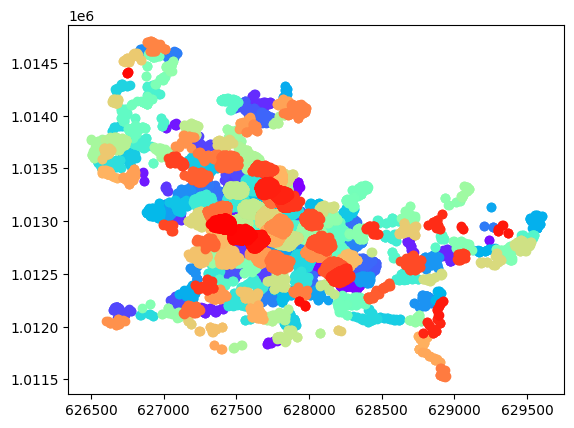

In [214]:
groups = distributed_groups
import matplotlib.pyplot as plt
from matplotlib import cm
colors = cm.rainbow([i/len(groups) for i in range(len(groups))])
for i, group in enumerate(groups):
    x = [point.x for point in group.members]
    y = [point.y for point in group.members]
#     x1 = [group.centroid.x]
#     y1 = [group.centroid.y]
    plt.scatter(x, y, color=colors[i], label=f"Group {i+1}")
#     plt.scatter(x1, y1, color='black', label=f"Group {i+1}")

# plt.legend()
plt.show()



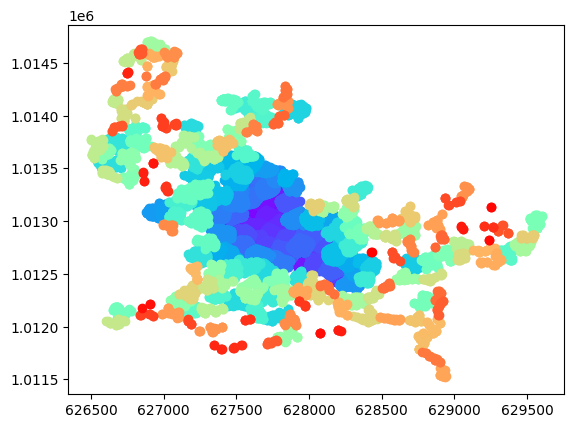

In [215]:
groups = optimized_groups
import matplotlib.pyplot as plt
from matplotlib import cm
colors = cm.rainbow([i/len(groups) for i in range(len(groups))])
for i, group in enumerate(groups):
    x = [point.x for point in group.members]
    y = [point.y for point in group.members]
#     x1 = [group.centroid.x]
#     y1 = [group.centroid.y]
    plt.scatter(x, y, color=colors[i], label=f"Group {i+1}")
#     plt.scatter(x1, y1, color='black', label=f"Group {i+1}")

# plt.legend()
plt.show()



## 2.5 Centroids from groups

In [216]:
centroids = [group.centroid for group in groups]
centroids = np.array([(point.x, point.y) for point in centroids ])


## 3. Voronoi Tesselation using centroids


As stated in the paper the above is a little irregular and not the best idea for generation of a aggregation cells in a trajectory. Adding more points to it so that it looks more regular

### Developing flow-field/movement vectors using voronoi cells
### 3.3 Partioning the territory - 

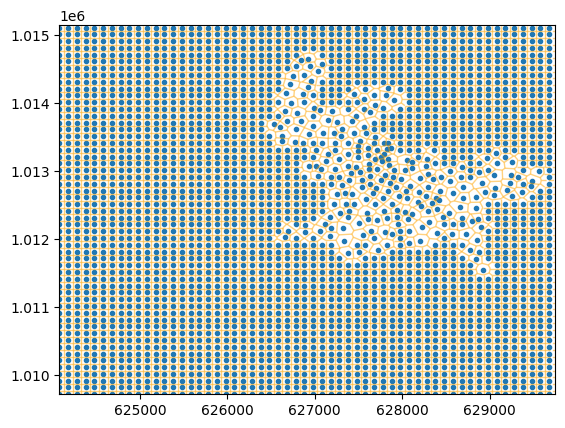

2930


In [225]:
from scipy.spatial import Voronoi, voronoi_plot_2d
import numpy as np
import shapely.geometry as geometry
import matplotlib.pyplot as plt


def plotVoronoiDiagram(centroids):
# Define the bounding box
    xMin, xMax, yMin, yMax = 624079.8465020715, 629752.8465020715, 1009715.5668793379, 1015157.5668793379


    # Define the cell width
    cellWidth = max_radius

    # Generate a set of points
    x, y = np.meshgrid(np.arange(xMin, xMax, cellWidth),
                       np.arange(yMin, yMax, cellWidth))
    points = np.column_stack((x.ravel(), y.ravel()))

    for centroid in centroids:
        points = points[(np.sqrt(np.sum((points - centroid)**2 , axis = 1)) > max_radius)]

    points = (np.concatenate((points, np.array(centroids)), axis = 0))
    # Compute the Voronoi diagram
    vor = Voronoi(points)
    fig = voronoi_plot_2d(vor, show_vertices=False, line_colors='orange', line_width=1, line_alpha=0.5)

    ax = fig.gca()

    # iterate over Voronoi regions and label cells with their indices
#     for i, region in enumerate(vor.regions):
#         if -1 not in region:  # ignore infinite regions
#             centroid = vor.vertices[region].mean(axis=0)
#             ax.text(centroid[0], centroid[1], str(i), color='red', ha='center', va='center')

    # Plot the Voronoi diagram


    plt.xlim([xMin, xMax])
    plt.ylim([yMin, yMax])
    plt.show()
    print(len(vor.regions))
    return vor

max_radius = 100
vor =plotVoronoiDiagram(centroids)

### 3.4 Diving Trajectories into segments 
Finding the cells of starting,ending with timeframes - finding the cells which are closest to the points


In [218]:
closest_region_indices = []
for p in extracted_points[['utm-easting', 'utm-northing']].to_numpy():
    distances = np.sqrt(np.sum((vor.points - p)**2, axis=1))
    closest_point_idx = np.argmin(distances)
    closest_region_idx = vor.point_region[closest_point_idx]
    closest_region_indices.append(closest_region_idx)

In [219]:
extracted_points['closest_cell'] = closest_region_indices

# 3.5 Aggregation of data

In [220]:
# Identify the rows where the value of the 'Name' column changes
mask = extracted_points['closest_cell'].ne(extracted_points['closest_cell'].shift())

# Save the rows where the value of the 'Name' column changes to a new DataFrame
result = extracted_points.loc[mask]

In [221]:
result = result [
    ['closest_cell', 'trajectory_number']
]

# assuming your dataframe is called 'df'
trajectory_column = 'trajectory_number'  # replace with the name of your column

# group by the trajectory column and convert to dictionary of lists
trajectory_dict = result.groupby(trajectory_column).apply(lambda x: x.drop(columns=trajectory_column).values.tolist()).to_dict()
trajectory_dict = {k: [item for sublist in v for item in sublist] for k, v in trajectory_dict.items()}


The above dictionary now has a list of cells each trajectory goes to. Trying to plot arrows from one cell to another and then plotting a different color for each of the 329 different trajectories

In [222]:
trajectory_dict

{0: [2622],
 1: [2096, 2295, 2806, 2717, 2718, 2616, 2615, 2623],
 2: [2615,
  2623,
  2615,
  2623,
  2615,
  2804,
  2802,
  2806,
  2802,
  2806,
  2097,
  2096,
  2097,
  1507,
  1003,
  2803,
  2804,
  2616,
  2303,
  2305,
  2300,
  2306,
  2617,
  2804,
  2615,
  2623],
 3: [2245,
  2243,
  966,
  1444,
  247,
  472,
  469,
  473,
  72,
  75,
  72,
  75,
  996,
  995,
  999,
  2096,
  2097,
  2806,
  2803,
  2299,
  2809,
  2808],
 4: [2616,
  2718,
  2616,
  2614,
  2806,
  2803,
  2802,
  2806,
  2097,
  2096,
  575,
  2095,
  1252,
  2095,
  2817,
  796,
  795,
  796,
  2812,
  2627,
  2717,
  2816,
  2305,
  2718,
  2615,
  2623],
 5: [2802,
  2806,
  2097,
  2096,
  2095,
  2815,
  2817,
  796,
  2817,
  796,
  2316,
  2810,
  2297,
  2621,
  204,
  456,
  208],
 6: [2623,
  2615,
  2804,
  2802,
  2806,
  2614,
  2805,
  2806,
  2295,
  2097,
  2096,
  999,
  574,
  24,
  50,
  24,
  574,
  575,
  2095,
  2096,
  2095,
  2096,
  999,
  995,
  24,
  23,
  995,
  1507,
  261

In [226]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

# generate some random points and compute Voronoi diagram
# cell_index
# list of cell indices to plot
cell_indices = trajectory_dict[int(input())]
print(cell_indices)
# compute centroids of each cell
centroids_voronoi = []
for i in cell_indices:
    region = vor.regions[vor.point_region[i]]
    if -1 not in region:
        centroid = np.mean([vor.vertices[j] for j in region], axis=0)
        centroids_voronoi.append(centroid)

# plot lines passing through centroids
# fig, ax = plt.subplots()
# for centroid in centroids_voronoi:
#     x, y = zip(*[centroid, (points[0].x , points[0].y)])
#     ax.plot(x, y, color='red')
    
# iterate over Voronoi regions and label cells with their indices
for i, region in enumerate(vor.regions):
    if -1 not in region:  # ignore infinite regions
        centroid = vor.vertices[region].mean(axis=0)
        ax.text(centroid[0], centroid[1], str(i), color='red', ha='center', va='center')


# plot Voronoi diagram
voronoi_plot_2d(vor, ax=ax)

# show plot
plt.show()


6
[2623, 2615, 2804, 2802, 2806, 2614, 2805, 2806, 2295, 2097, 2096, 999, 574, 24, 50, 24, 574, 575, 2095, 2096, 2095, 2096, 999, 995, 24, 23, 995, 1507, 2614, 2305, 2617, 2615, 2623]


/var/folders/2z/k0vctg855l3dq626nd2hf5j40000gn/T/ipykernel_12104/923512828.py:27: RuntimeWarning: Mean of empty slice.
  centroid = vor.vertices[region].mean(axis=0)


In [224]:
points[0]